In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os

# create element tree object
tree = ET.parse('data/export.xml') 
# for every health record, extract the attributes
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]

In [2]:
# Define an empty list to store extracted data
workout_data = []

xml_directory = os.path.dirname('data/export.xml')

# Iterate through each Workout element in the XML
for workout in root.findall('Workout'):
    # Extract relevant attributes
    workout_activity_type = workout.attrib.get('workoutActivityType')
    duration = float(workout.attrib.get('duration', 0))
    duration_unit = workout.attrib.get('durationUnit')
    source_name = workout.attrib.get('sourceName')
    source_version = workout.attrib.get('sourceVersion')
    device = workout.attrib.get('device')
    creation_date = workout.attrib.get('creationDate')
    start_date = workout.attrib.get('startDate')
    end_date = workout.attrib.get('endDate')
    
    # Extract energy burned and elevation gain from WorkoutStatistics elements
    energy_burned = 0
    elevation_gain = 0
    for stat in workout.findall('.//WorkoutStatistics'):
        stat_type = stat.attrib.get('type')
        if stat_type == 'HKQuantityTypeIdentifierActiveEnergyBurned':
            energy_burned = float(stat.attrib.get('sum', 0))
        elif stat_type == 'HKQuantityTypeIdentifierAppleExerciseTime': # assuming elevation gain is measured in this type
            elevation_gain = float(stat.attrib.get('sum', 0))

    # Extract GPX path from WorkoutRoute elements
    gpx_path = ""
    for route in workout.findall('.//WorkoutRoute'):
        file_reference = route.find("./FileReference[@path]")
        if file_reference is not None:
            relative_path = file_reference.get('path')
            gpx_path = os.path.join(xml_directory, relative_path)

    # Append the extracted data to the list
    workout_data.append({
        'workoutActivityType': workout_activity_type,
        'duration': duration,
        'durationUnit': duration_unit,
        'sourceName': source_name,
        'sourceVersion': source_version,
        'device': device,
        'creationDate': creation_date,
        'startDate': start_date,
        'endDate': end_date,
        'energyBurned': energy_burned,
        'elevationGain': elevation_gain,
        'gpxPath': gpx_path
    })

# Convert the list of dictionaries into a pandas DataFrame
workout_df = pd.DataFrame(workout_data)

# Display the DataFrame
workout_df.head()


,workoutActivityType,duration,durationUnit,sourceName,sourceVersion,device,creationDate,startDate,endDate,energyBurned,elevationGain,gpxPath
0,HKWorkoutActivityTypeWalking,57.325298,min,Harikrishna’s Apple Watch,6.2.5,"<<HKDevice: 0x283bac5f0>, name:Apple Watch, ma...",2020-06-23 12:06:38 -0600,2020-06-23 11:09:14 -0600,2020-06-23 12:06:34 -0600,313.025,0,/workout-routes/route_2020-06-23_1.06pm.gpx
1,HKWorkoutActivityTypeWalking,72.032875,min,Harikrishna’s Apple Watch,6.2.5,"<<HKDevice: 0x283bac5f0>, name:Apple Watch, ma...",2020-06-24 12:19:52 -0600,2020-06-24 11:07:43 -0600,2020-06-24 12:19:45 -0600,384.589,0,/workout-routes/route_2020-06-24_1.19pm.gpx
2,HKWorkoutActivityTypeWalking,57.167760,min,Harikrishna’s Apple Watch,6.2.8,"<<HKDevice: 0x283bac500>, name:Apple Watch, ma...",2020-08-24 11:25:00 -0600,2020-08-24 10:26:58 -0600,2020-08-24 11:24:53 -0600,343.491,0,/workout-routes/route_2020-08-24_12.24pm.gpx
3,HKWorkoutActivityTypeWalking,59.581077,min,Harikrishna’s Apple Watch,6.2.8,"<<HKDevice: 0x283bac500>, name:Apple Watch, ma...",2020-08-25 10:58:57 -0600,2020-08-25 09:57:03 -0600,2020-08-25 10:58:51 -0600,292.412,0,/workout-routes/route_2020-08-25_11.56am.gpx
4,HKWorkoutActivityTypeWalking,82.133357,min,Harikrishna’s Apple Watch,6.2.8,"<<HKDevice: 0x283bac500>, name:Apple Watch, ma...",2020-08-26 11:07:41 -0600,2020-08-26 09:45:22 -0600,2020-08-26 11:07:30 -0600,404.947,0,/workout-routes/route_2020-08-26_12.07pm.gpx


In [3]:
# Remove 'HKWorkoutActivityType' prefix from 'workoutActivityType' column
workout_df['workoutActivityType'] = workout_df['workoutActivityType'].str.replace('HKWorkoutActivityType', '')

# Display unique values
workout_df['workoutActivityType'].value_counts()

workoutActivityType
Walking                          250
TraditionalStrengthTraining       89
Running                           57
HighIntensityIntervalTraining     29
FunctionalStrengthTraining        22
Elliptical                        17
Cycling                            9
CrossTraining                      3
Hiking                             3
StairClimbing                      1
Name: count, dtype: int64

In [27]:
import geopandas as gpd

locations = gpd.read_file("data/workout-routes/route_2023-01-04_5.42pm.gpx", layer="tracks")

locations.head()

,name,cmt,desc,src,link1_href,link1_text,link1_type,link2_href,link2_text,link2_type,number,type,geometry
0,Route 2023-01-04 5:42pm,None,None,None,None,None,None,None,None,None,None,None,"MULTILINESTRING ((-121.99273 47.54681, -121.99..."


In [28]:
locations.to_crs(epsg=2062, inplace=True)
locations.crs

<Projected CRS: EPSG:2062>
Name: Madrid 1870 (Madrid) / Spain LCC
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Spain - mainland onshore.
- bounds: (-9.37, 35.95, 3.39, 43.82)
Coordinate Operation:
- name: Spain
- method: Lambert Conic Conformal (1SP)
Datum: Madrid 1870 (Madrid)
- Ellipsoid: Struve 1860
- Prime Meridian: Madrid

In [29]:
locations['geometry']

0    MULTILINESTRING ((-5963341.621 6572026.736, -5...
Name: geometry, dtype: geometry

<Axes: >

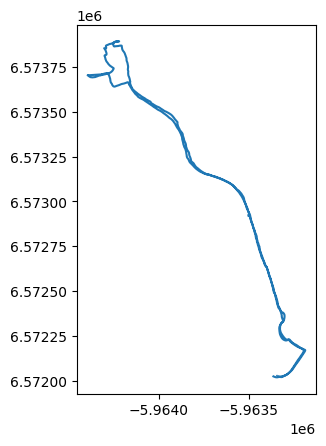

In [32]:
locations.plot()

In [39]:
import folium 
import gpxpy
import os

In [53]:
def overlayGPX(gpxData, zoom = 15):
    '''
    overlay a gpx route on top of an OSM map using Folium
    some portions of this function were adapted
    from this post: https://stackoverflow.com/questions/54455657/
    how-can-i-plot-a-map-using-latitude-and-longitude-data-in-python-highlight-few
    '''
    gpx_file = open(gpxData, 'r')
    gpx = gpxpy.parse(gpx_file)
    points = []
    for track in gpx.tracks:
        for segment in track.segments:        
            for point in segment.points:
                points.append(tuple([point.latitude, point.longitude]))
    latitude = sum(p[0] for p in points)/len(points)
    longitude = sum(p[1] for p in points)/len(points)
    myMap = folium.Map(location=[latitude,longitude],zoom_start=zoom)
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(myMap)
    return (myMap)

In [55]:
baseDir = 'data/workout-routes'
fileName = 'route_2023-01-04_5.42pm.gpx'
filePath = os.path.join(baseDir,fileName)
overlayGPX(filePath)